## Neuropathy

----------------------------------

### 1. Import packages

In [ ]:
#!conda install -c https://conda.anaconda.org/plotly plotly -y
#!pip install pydot
#!pip install graphviz
#!conda install -c anaconda py-xgboost -y
#!pip install shap
#!pip install dill
#pip install matplotlib
#pip install seaborn
#pip install missingpy
#!pip3 install pickle5
#pip install statannot

In [1]:
import pandas as pd
import sqlite3 as sql
import numpy as np
from IPython.display import HTML
from datetime import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # set plot style
from collections import Counter
import scipy as sp
import sklearn as sk
import sys
import plotly.express as px
import pydot
import pickle
import time
import xgboost as xgb
import shap
import dill
import gc
import subprocess
import pickle5 as pickle
import sklearn.metrics as metrics
from scipy.stats import ranksums, ttest_ind
from statsmodels.stats.weightstats import ztest
import pylab 
import scipy.stats as stats
from scipy.stats import chi2_contingency
from matplotlib import rc
from cycler import cycler
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from statannot import add_stat_annotation

In [2]:
import os
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

from collections import defaultdict

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import time

### 2. Removing pts w/ neuro diff=NaN from Output

In [4]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/comps_over1mo_df.pkl', 'rb') as handle:
    comps_over1mo_df = pickle.load(handle) 

In [5]:
#1mo
neuro_time = comps_over1mo_df.NEUROPATH_diff.copy()
neuro_time_drop=neuro_time.replace(np.nan, 'Drop', inplace=False)
neuro_index = neuro_time_drop [neuro_time_drop == 'Drop'].index
print("Total Length: ", neuro_time_drop.shape)
print("Number to be dropped: ", neuro_time_drop[neuro_time_drop == 'Drop'].shape)
# dropping the NaNs from our OUTput data
neuro_time_drop.drop(neuro_index, inplace=True)
neuro_time_final = neuro_time_drop.astype('float64')
print('Output dataset size:', neuro_time_final.shape)

Total Length:  (30854,)
Number to be dropped:  (22222,)
Output dataset size: (8632,)


### 3. Two way drop from input and output

In [6]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/phen_demos_vit_soc_lab.pkl', 'rb') as handle:
    phen_demos_vit_soc_lab = pickle.load(handle)

In [7]:
def drop_opth_list(output_df,input_df):
    extra_list=list(set(input_df.index.tolist())-set(output_df.index.tolist()))
    input_df_new=input_df.drop(extra_list)
    extra_list_rev=list(set(output_df.index.tolist())-set(input_df_new.index.tolist()))
    output_df_new=output_df.drop(extra_list_rev)
    print('length of input_df:', len(input_df))
    print('length of opth_df:', len(output_df))
    print('length of # to drop from  input:',len(extra_list))
    print('length of # to drop from  opth:',len(extra_list_rev))
    print('length of input_df after dropping',len(input_df_new))
    print('length of opth_df after dropping',len(output_df_new))
    print('Indexes equal?', np.all(input_df_new.index == output_df_new.index))
    return output_df_new, input_df_new

In [8]:
phen_demos_vit_soc_lab.shape

(15987, 1824)

In [9]:
neuro_time_final.shape

(8632,)

In [10]:
neuro_final, all_inputs=drop_opth_list(neuro_time_final, phen_demos_vit_soc_lab)

length of input_df: 15987
length of opth_df: 8632
length of # to drop from  input: 11730
length of # to drop from  opth: 4375
length of input_df after dropping 4257
length of opth_df after dropping 4257
Indexes equal? True


### 4. Make output diff times categorical using median as cut-off

In [11]:
neuro_final.median()

3.2608472453233124

In [12]:
neuro_final.max()

15.644400637932332

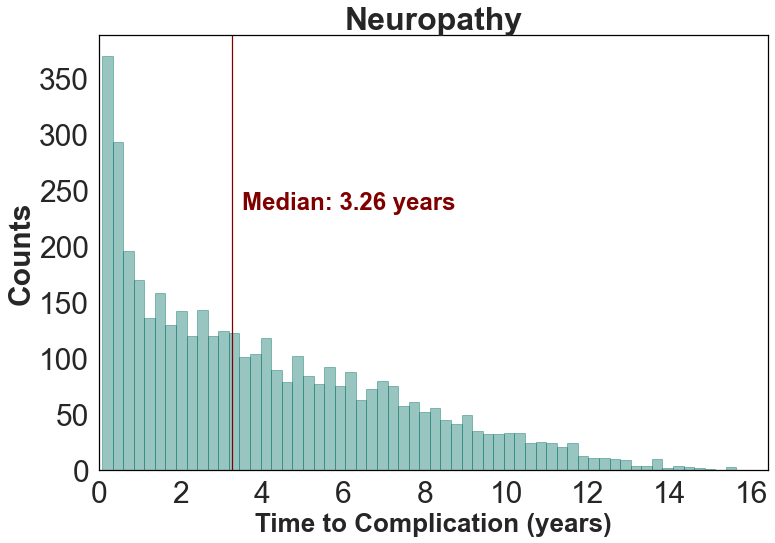

In [13]:
plt.figure(figsize=(12,8))
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
h = plt.hist(neuro_final, edgecolor='#007066', 
             bins=60, alpha=0.4,
             color='#007066')
h = plt.axvline(neuro_final.median(), color='maroon', linestyle='solid', linewidth=1.25)
min_ylim, max_ylim = plt.ylim()
plt.text(neuro_final.median()*1.08, max_ylim*0.6, 
         'Median: {:.2f} years'.format(neuro_final.median()),
         fontsize=24, fontweight=600, color='maroon')
plt.xlim(left=0.0)
plt.xlabel('Time to Complication (years)', fontsize=26, fontweight=600)
plt.ylabel('Counts', fontsize=30, fontweight=600)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Neuropathy", fontsize=32, fontweight=600)
plt.savefig(r'/Users/amomenzadeh/Desktop/DM_figures/neuro_hist.svg', format='svg')
plt.show()

In [14]:
#assign 0 if neuro complication occurred > neuro diff median 
#assign 1 if neuro complication occurred < neuro diff median 
neuro_final_clf = neuro_final.copy()
neuro_final_clf = pd.Series(np.where((neuro_final_clf > neuro_final.median()), 0, neuro_final_clf), 
                            index=neuro_final_clf.index)
neuro_final_clf = pd.Series(np.where((neuro_final_clf > 0), 1, neuro_final_clf), 
                            index=neuro_final_clf.index)

In [15]:
num_negs = neuro_final_clf.value_counts()[0]
num_pos = neuro_final_clf.value_counts()[1]
neg_prop = num_negs/(num_negs + num_pos)
print(str(round(neg_prop*100,2)), '% negative', sep='')
print(str(100-round(neg_prop*100,2)), '% positive', sep='')

49.99% negative
50.01% positive


In [16]:
neuro_final_clf.shape

(4257,)

In [ ]:
with open(r'./pickles/neuro_final.pkl', 'wb') as handle:
    pickle.dump(neuro_final, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/neuro_final_clf.pkl', 'wb') as handle:
    pickle.dump(neuro_final_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 5. Final Inputs

In [17]:
neuro_phen=all_inputs.iloc[:,:-103]
print(neuro_phen.columns)

Index(['ASCVD', 'Abdominal aortic aneurysm', 'Abdominal hernia',
       'Abdominal pain',
       'Abnormal Papanicolaou smear of cervix and cervical HPV',
       'Abnormal arterial blood gases', 'Abnormal chest sounds',
       'Abnormal coagulation profile',
       'Abnormal electrocardiogram [ECG] [EKG]',
       'Abnormal findings examination of lungs',
       ...
       'Vitamin B-complex deficiencies', 'Vitamin D deficiency',
       'Vitamin deficiency', 'Vitiligo', 'Voice disturbance',
       'Von willebrand's disease', 'Wegener's granulomatosis', 'Wheezing',
       'severe protein-calorie malnutrition', 'stress incontinence, female'],
      dtype='object', length=1721)


In [22]:
neuro_all=all_inputs.drop(['duration_diab','vital_status_Alive','vital_status_Deceased'],axis=1)

In [24]:
neuro_demos_norm=neuro_all.iloc[:,-100:-70]
neuro_demos_norm.columns

Index(['age_at_diab', 'sex_Female', 'sex_Male', 'marital_status_Divorced',
       'marital_status_Legally Separated', 'marital_status_Married',
       'marital_status_Patient Refused', 'marital_status_Significant Other',
       'marital_status_Single', 'marital_status_Unknown',
       'marital_status_Widowed', 'employment_status_Disabled',
       'employment_status_Full Time', 'employment_status_Not Employed',
       'employment_status_On Active Military Duty',
       'employment_status_Part Time', 'employment_status_Patient Refused',
       'employment_status_Retired', 'employment_status_Self Employed',
       'employment_status_Student - Full Time',
       'employment_status_Student - Part Time', 'employment_status_Unknown',
       'race_American Indian or Alaska Native', 'race_Asian',
       'race_Black or African American', 'race_Multiracial',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Other',
       'race_Unknown', 'race_White or Caucasian'],
      dtype='objec

In [25]:
neuro_vitals_norm=neuro_all.iloc[:,-70:-64]
neuro_vitals_norm.columns

Index(['bmi', 'bp_diastolic', 'bp_systolic', 'pulse', 'temperature',
       'respiration'],
      dtype='object')

In [26]:
neuro_social_norm=neuro_all.iloc[:,-64:-35]
neuro_social_norm.columns

Index(['alcohol_use_name_Never', 'alcohol_use_name_No',
       'alcohol_use_name_Not Asked', 'alcohol_use_name_Not Currently',
       'alcohol_use_name_Yes', 'ill_drug_user_name_Never',
       'ill_drug_user_name_No', 'ill_drug_user_name_Not Asked',
       'ill_drug_user_name_Not Currently', 'ill_drug_user_name_Yes',
       'tobacco_user_name_Never', 'tobacco_user_name_Not Asked',
       'tobacco_user_name_Passive', 'tobacco_user_name_Quit',
       'tobacco_user_name_Yes', 'cigarettes_yn_N', 'cigarettes_yn_Y',
       'pipes_yn_N', 'pipes_yn_Y', 'cigars_yn_N', 'cigars_yn_Y', 'snuff_yn_N',
       'snuff_yn_Y', 'chew_yn_N', 'chew_yn_Y',
       'smokeless_tob_use_name_Current User',
       'smokeless_tob_use_name_Former User',
       'smokeless_tob_use_name_Never Used', 'smokeless_tob_use_name_Unknown'],
      dtype='object')

In [27]:
neuro_labs_norm=neuro_all.iloc[:,-35:]
neuro_labs_norm.columns

Index(['PLATELET COUNT', 'AST/SGOT', 'CALCIUM', 'GLUCOSE', 'BICARBONATE',
       'CHLORIDE', 'POTASSIUM', 'HEMATOCRIT', 'WHITE BLOOD CELL COUNT',
       'CREATININE', 'TOTAL PROTEIN', 'ALBUMIN', 'BLOOD UREA NITROGEN',
       'ANION GAP', 'EGFR', 'EGFR FOR AFRICAN AMERICANS', 'SODIUM',
       'BILIRUBIN TOTAL', 'ALKALINE PHOSPHATASE', 'ALT/SGPT', 'HEMOGLOBIN',
       'RED BLOOD CELL COUNT', 'MEAN CORPUSCULAR HGB',
       'MEAN CORPUSCULAR VOLUME', 'MEAN PLATELET VOLUME',
       'RED CELL DISTRIBUTION WIDTH', 'MEAN CORPUSCULAR HGB CONCENTRN',
       'MONOCYTE PERCENT', 'NEUTROPHIL PERCENT', 'EOSINOPHIL PERCENT',
       'LYMPH PERCENT', 'NEUTROPHIL ABSOLUTE', 'LYMPHOCYTE ABSOLUTE',
       'MONOCYTE ABSOLUTE', 'EOSINOPHIL ABSOLUTE'],
      dtype='object')

In [231]:
with open(r'./pickles/neuro_all.pkl', 'wb') as handle:
    pickle.dump(neuro_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/neuro_phen.pkl', 'wb') as handle:
    pickle.dump(neuro_phen, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/neuro_demos_norm.pkl', 'wb') as handle:
    pickle.dump(neuro_demos_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/neuro_vitals_norm.pkl', 'wb') as handle:
    pickle.dump(neuro_vitals_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/neuro_social_norm.pkl', 'wb') as handle:
    pickle.dump(neuro_social_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/neuro_labs_norm.pkl', 'wb') as handle:
    pickle.dump(neuro_labs_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 6. Make Table 1

In [31]:
with open(r'./pickles/phen_prediab_bin.pkl', 'rb') as handle:
    phen_prediab_bin = pickle.load(handle)
with open(r'./pickles/social_df.pkl', 'rb') as handle:
    social_df = pickle.load(handle)
with open(r'./pickles/vitals_df.pkl', 'rb') as handle:
    vitals_df = pickle.load(handle)
with open(r'./pickles/imp_labs.pkl', 'rb') as handle:
    imp_labs = pickle.load(handle)
with open(r'./pickles/neuro_final_clf.pkl', 'rb') as handle:
    neuro_final_clf = pickle.load(handle)

In [7]:
demos_all = pd.read_csv(r'/Users/amomenzadeh/Desktop/DM_csv/demos_all.csv',low_memory=False)

In [8]:
demos_R = pd.read_csv(r'/Users/amomenzadeh/Desktop/DM_csv/demos_from_R.csv',low_memory=False)

In [55]:
demos_R['patient_num'] = demos_all['patient_num'].values

In [56]:
demos_R=demos_R.set_index('patient_num')

In [57]:
neuro_df=neuro_final_clf.to_frame(name='class')
neuro_df.shape

(4257, 1)

In [58]:
all_neu=demos_R.merge(neuro_df,left_index=True, right_index=True)
all_neu.shape

(4257, 8)

In [59]:
all_neu=all_neu.merge(imp_labs,left_index=True, right_index=True)
all_neu.shape

(4257, 43)

In [60]:
all_neu=all_neu.merge(vitals_df,left_index=True, right_index=True)
all_neu.shape

(4257, 49)

In [61]:
all_neu=all_neu.merge(social_df,left_index=True, right_index=True)
all_neu.shape

(4257, 58)

In [62]:
all_neu=all_neu.merge(phen_prediab_bin,left_index=True, right_index=True)
all_neu.shape

(4257, 1779)

In [63]:
i_o_fast=all_neu.loc[all_neu['class'] == 1]

In [64]:
i_o_slow=all_neu.loc[all_neu['class'] == 0]

In [65]:
print("\n--Median Slow---\n")
print(i_o_slow[['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']].median())
print("\n---Median Fast---\n")
print(i_o_fast[['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']].median())


--Median Slow---

age_at_diab       55.723252
duration_diab     10.728762
GLUCOSE          160.500000
CREATININE         0.861500
bmi               34.084288
EGFR              60.000000
dtype: float64

---Median Fast---

age_at_diab       58.867739
duration_diab      5.967541
GLUCOSE          166.000000
CREATININE         0.861500
bmi               33.628500
EGFR              60.000000
dtype: float64


In [66]:
print("\n--IQR Slow---\n")
print(i_o_slow[['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']].describe())
print("\n--IQR Fast---\n")
print(i_o_fast[['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']].describe())


--IQR Slow---

       age_at_diab  duration_diab      GLUCOSE   CREATININE          bmi  \
count  2128.000000    2128.000000  2128.000000  2128.000000  2128.000000   
mean     54.795566      10.549905   178.145028     0.917163    34.388086   
std      14.338656       2.858103    80.077312     0.247623     6.627134   
min      14.749105       0.172488     4.000000     0.200000    15.850000   
25%      45.640910       8.434395   119.000000     0.780000    30.250000   
50%      55.723252      10.728762   160.500000     0.861500    34.084288   
75%      64.976009      12.675413   204.970000     1.000000    37.959800   
max      93.201092      17.086182   508.000000     2.000000    60.840000   

              EGFR  
count  2128.000000  
mean     62.982130  
std      11.519713  
min      17.200000  
25%      60.000000  
50%      60.000000  
75%      65.860000  
max     100.000000  

--IQR Fast---

       age_at_diab  duration_diab      GLUCOSE   CREATININE          bmi  \
count  2129.000000

In [67]:
cat_variables=['sex', 'race', 'Essential hypertension','Hyperlipidemia','cigarettes_yn','smokeless_tob_use_name']

In [68]:
for i in cat_variables:
    print(i)
    print('Slow counts:', i_o_slow[i].value_counts())
    print('Slow percents:', i_o_slow[i].value_counts(normalize=True)*100)
    print('++++++++++++++++++++++++++++++++++++++')
    print(i)
    print('Fast counts:', i_o_fast[i].value_counts())
    print('Fast percents:', i_o_fast[i].value_counts(normalize=True)*100)
    print('++++++++++++++++++++++++++++++++++++++')

sex
Slow counts: Female    1138
Male       990
Name: sex, dtype: int64
Slow percents: Female    53.477444
Male      46.522556
Name: sex, dtype: float64
++++++++++++++++++++++++++++++++++++++
sex
Fast counts: Female    1090
Male      1039
Name: sex, dtype: int64
Fast percents: Female    51.197745
Male      48.802255
Name: sex, dtype: float64
++++++++++++++++++++++++++++++++++++++
race
Slow counts: White or Caucasian                  1345
Black or African American            682
Other                                 70
Asian                                 20
American Indian or Alaska Native       8
Multiracial                            3
Name: race, dtype: int64
Slow percents: White or Caucasian                  63.204887
Black or African American           32.048872
Other                                3.289474
Asian                                0.939850
American Indian or Alaska Native     0.375940
Multiracial                          0.140977
Name: race, dtype: float64
+++++++++++

In [72]:
for i in cat_variables:
    print(i)
    crosstab = pd.crosstab(all_neu[i], all_neu['class'])
    print('chi-square:',stats.chi2_contingency(crosstab))
    print('+++++++++++++++++++++++++++++++++++++++')

sex
chi-square: (2.1267721286788706, 0.14474528450344543, 1, array([[1113.73831337, 1114.26168663],
       [1014.26168663, 1014.73831337]]))
+++++++++++++++++++++++++++++++++++++++
race
chi-square: (23.457329241171774, 0.000656921757197881, 6, array([[   7.4982382 ,    7.5017618 ],
       [  28.99318769,   29.00681231],
       [ 624.85318299,  625.14681701],
       [   2.49941273,    2.50058727],
       [   1.99953019,    2.00046981],
       [  74.48249941,   74.51750059],
       [1387.67394879, 1388.32605121]]))
+++++++++++++++++++++++++++++++++++++++
Essential hypertension
chi-square: (2.21766561924294, 0.1364392204470528, 1, array([[ 829.80502701,  830.19497299],
       [1298.19497299, 1298.80502701]]))
+++++++++++++++++++++++++++++++++++++++
Hyperlipidemia
chi-square: (9.206407864553725, 0.002411694516485715, 1, array([[1513.64435048, 1514.35564952],
       [ 614.35564952,  614.64435048]]))
+++++++++++++++++++++++++++++++++++++++
cigarettes_yn
chi-square: (6.087644454897466, 0.0136

In [71]:
listofname=['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']

for x in listofname:
    print(x)
    print('fast var normality:', stats.shapiro(i_o_fast[x]))
    print('slow var normality:',stats.shapiro(i_o_slow[x]))
    
    #print('t-test: ',ttest_ind(i_o_fast[x],i_o_slow[x], equal_var=True))
    print('ranksum: ',ci_o_fast[x],i_o_slow[x]))
    #print('z-test: ', ztest(i_o_fast[x],i_o_slow[x]))
    print('+++++++++++++++++++++++++++++++++++++++')

age_at_diab
fast var normality: ShapiroResult(statistic=0.9931840896606445, pvalue=2.2115365538866172e-08)
slow var normality: ShapiroResult(statistic=0.992682695388794, pvalue=7.890268882704277e-09)
ranksum:  RanksumsResult(statistic=7.357325554679423, pvalue=1.876313635786395e-13)
+++++++++++++++++++++++++++++++++++++++
duration_diab
fast var normality: ShapiroResult(statistic=0.9695741534233093, pvalue=7.911938938217095e-21)
slow var normality: ShapiroResult(statistic=0.9881847500801086, pvalue=3.111250840293067e-12)
ranksum:  RanksumsResult(statistic=-36.31011718017185, pvalue=1.120255909679564e-288)
+++++++++++++++++++++++++++++++++++++++
GLUCOSE
fast var normality: ShapiroResult(statistic=0.9012157917022705, pvalue=5.138683886112948e-35)
slow var normality: ShapiroResult(statistic=0.8968486785888672, pvalue=1.3266806887668217e-35)
ranksum:  RanksumsResult(statistic=2.0736335341466265, pvalue=0.03811335833994221)
+++++++++++++++++++++++++++++++++++++++
CREATININE
fast var normalit

### 7. Random Search on MCW cluster

In [ ]:
#inputs
input_dict = {
    'Codes': neuro_phen,
    'Demos': neuro_demos,
    'Vitals': neuro_vitals,
    'Social':neuro_social,
    'Labs': neuro_labs,
    'All': neuro_all}

#parameters
Dummy_params = {'strategy':['most_frequent']}

GB_params = {
    'learning_rate': np.linspace(0.1, 1, 19),
    'max_depth': np.linspace(5, 100, 20),
    'max_features': ['auto','sqrt','log2'],
    'min_samples_leaf': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_samples_split': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'subsample':[0.8, 1],
    'n_estimators':[10, 50, 100, 250, 500, 1000, 2000, 3000]}

SVC_params = {
    'C': [0.1,1,10,100],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'gamma':[1,0.1,0.01,0.001]}

ET_params = {
    'bootstrap': [True, False],
    'max_depth': np.linspace(5, 100, 20),
    'max_features':['auto','sqrt','log2'],
    'min_samples_leaf': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_samples_split': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'n_estimators':[10, 50, 100, 250, 500, 1000, 2000, 3000]}

RF_params = {
    'bootstrap': [True, False],
    'max_depth': np.linspace(5, 100, 20),
    'max_features':['auto','sqrt','log2'],
    'min_samples_leaf': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_samples_split': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'n_estimators':[10, 50, 100, 250, 500, 1000, 2000, 3000]}

ada_params = {
    'learning_rate': np.linspace(0.1, 1, 19),
    'n_estimators':[10, 50, 100, 250, 500, 1000, 2000, 3000]}

LR_params = {
            'C':[0.01,0.1,1,10,100],
            'penalty':['l2','none'],
            'solver':['newton-cg','lbfgs', 'sag', 'saga'],
            'max_iter':[100,200,300]}
            
models_dict = {
    'Dummy': DummyClassifier(),
    'SVC': SVC(probability=True),
    'GB': GradientBoostingClassifier(),
    'ET': ExtraTreesClassifier(),
    'RF': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LR': LogisticRegression()}

params_dict = {
    'Dummy': Dummy_params,
    'SVC': SVC_params,
    'GB': GB_params,
    'ET': ET_params,
    'RF': RF_params,
    'AdaBoost': ada_params,
    'LR': LR_params}

#run randomsearch
neuro_all_score_dict = {}
neuro_all_model_dict = {}

for i in input_dict.keys():
    print('Input:', i)
    temp_1 = {}
    temp_2 = {}
    Xtrain, Xtest, ytrain, ytest = train_test_split(input_dict[i], neuro_final_clf, random_state=42, test_size=0.2) 
    for x in models_dict.keys():
        print(x)
        clf = RandomizedSearchCV(models_dict[x], param_distributions= params_dict[x],scoring='roc_auc',refit=True,cv=5, n_jobs=47,verbose=3, n_iter=1000)
        clf.fit(Xtrain, ytrain)
        print(clf.best_estimator_)
        print(clf.best_score_)
        temp_1[x] = clf.best_estimator_
        temp_2[x] = clf.best_score_
    neuro_all_model_dict[i] = temp_1
    neuro_all_score_dict[i] = temp_2

# save
with open('neuro_phenbin_all_score_dict.pkl', 'wb') as tmpfile:
    pickle.dump(neuro_all_score_dict, tmpfile)
with open('neuro_phenbin_all_model_dict.pkl', 'wb') as tmpfile:
    pickle.dump(neuro_all_model_dict, tmpfile)

neuro_score_df=pd.DataFrame.from_dict(neuro_all_score_dict)
neuro_score_df.to_csv('neuro_phenbin_score_df.csv')

In [29]:
with open(r'./pickles/neuro_phenbin_all_model_dict.pkl', 'rb') as handle:
    neuro_all_model_dict = pickle.load(handle)
with open(r'./pickles/neuro_phenbin_all_score_dict.pkl', 'rb') as handle:
    neuro_all_score_dict = pickle.load(handle)

### 8. Evaluate test set

In [38]:
with open(r'./pickles/neuro_all.pkl', 'rb') as handle:
    neuro_all = pickle.load(handle)
with open(r'./pickles/neuro_phen.pkl', 'rb') as handle:
    neuro_phen = pickle.load(handle)
with open(r'./pickles/neuro_demos_norm.pkl', 'rb') as handle:
    neuro_demos = pickle.load(handle)
with open(r'./pickles/neuro_social_norm.pkl', 'rb') as handle:
    neuro_social = pickle.load(handle)
with open(r'./pickles/neuro_vitals_norm.pkl', 'rb') as handle:
    neuro_vitals = pickle.load(handle)
with open(r'./pickles/neuro_labs_norm.pkl', 'rb') as handle:
    neuro_labs = pickle.load(handle)
with open(r'./pickles/neuro_final_clf.pkl', 'rb') as handle:
    neuro_final_clf = pickle.load(handle)

In [31]:
neuro_score_df = pd.read_csv(r'/Users/amomenzadeh/Desktop/DM_csv/neuro_phenbin_score_df.csv',low_memory=False)

In [32]:
#train data (80%)
neuro_score_df

,Unnamed: 0,Codes,Demos,Vitals,Social,Labs,All
0,Dummy,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
1,SVC,0.644772,0.626187,0.550071,0.679791,0.665915,0.737861
2,GB,0.644948,0.634357,0.549844,0.687774,0.667440,0.744522
3,ET,0.659338,0.614063,0.559436,0.684268,0.669495,0.746353
4,RF,0.660152,0.634783,0.553288,0.684804,0.671516,0.747347
5,AdaBoost,0.611622,0.636074,0.549158,0.672051,0.660124,0.745259
6,LR,0.632961,0.625830,0.522481,0.672284,0.669122,0.735467


In [27]:
input_dict = {
    'Codes': neuro_phen,
    'Demos': neuro_demos,
    'Vitals': neuro_vitals,
    'Social': neuro_social,
    'Labs': neuro_labs,
    'All': neuro_all}

In [28]:
auroc = {}
fpr = {}
tpr = {}
threshold = {}

for x in neuro_all_model_dict.keys():
    temp1 = {}
    temp2 = {}
    temp3 = {}
    temp4 = {} 
    Xtrain, Xtest, ytrain, ytest = train_test_split(input_dict[x], neuro_final_clf, random_state=42, test_size=0.2) 
    for y in neuro_all_model_dict[x].keys():
        model= neuro_all_model_dict[x][y]
        ypred = model.predict(Xtest)
        probs = model.predict_proba(Xtest)
        pos_probs = probs[:, 1]
        temp1[y] = roc_auc_score(ytest, pos_probs)
        temp2[y], temp3[y], temp4[y] = metrics.roc_curve(ytest, pos_probs)
    auroc[x] = temp1
    fpr[x] = temp2
    tpr[x] = temp3
    threshold [x] = temp4

In [33]:
#test data(20%)
pd.DataFrame.from_dict(auroc)

,Codes,Demos,Vitals,Social,Labs,All
Dummy,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
SVC,0.632897,0.578871,0.565155,0.631922,0.648462,0.725636
GB,0.629216,0.582417,0.558617,0.665722,0.666096,0.712906
ET,0.634159,0.582740,0.573983,0.679567,0.661401,0.731913
RF,0.638331,0.582255,0.578292,0.673935,0.671387,0.736999
AdaBoost,0.614274,0.590149,0.583114,0.679187,0.663859,0.726959
LR,0.623777,0.583412,0.524536,0.677203,0.645084,0.724077


### 9. Make overlayed AUROC plot

In [49]:
# Set the global font to be DejaVu Sans, size 10 
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
# Set the font used for MathJax
rc('mathtext',**{'default':'regular'})
%matplotlib inline
# The following %config line changes the inline figures to have a higher DPI.
%config InlineBackend.figure_format = 'retina'

<Figure size 504x504 with 0 Axes>

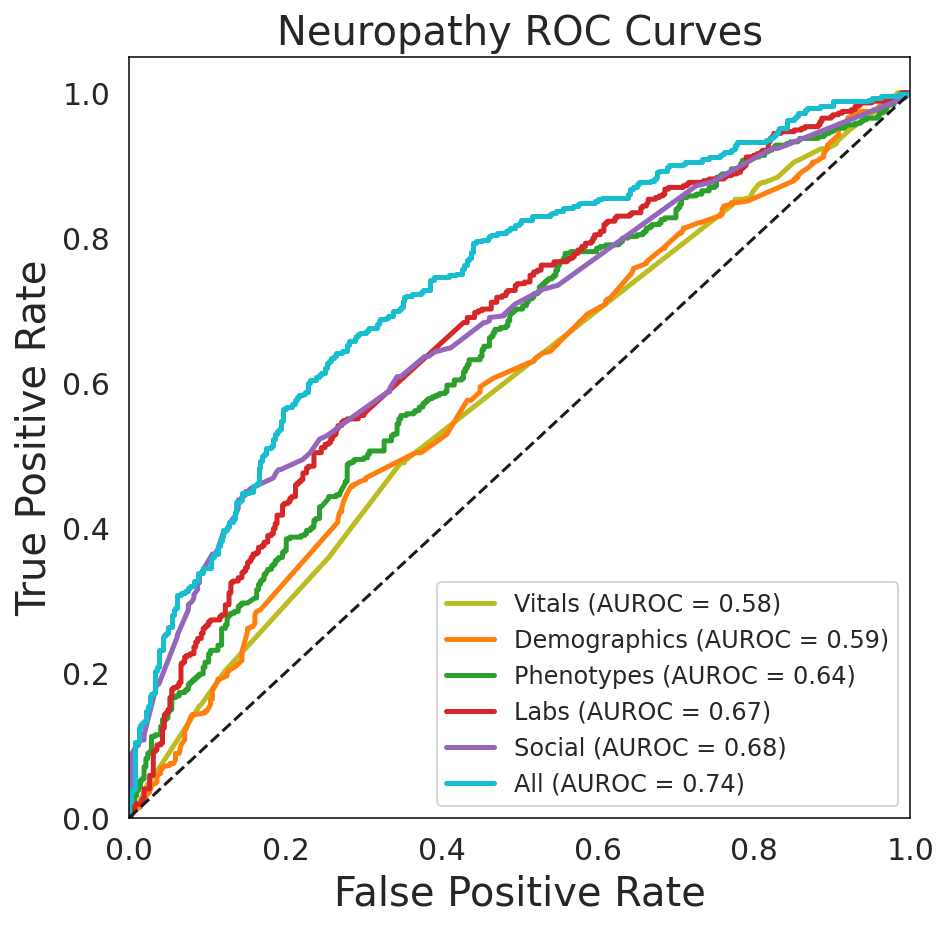

<Figure size 504x504 with 0 Axes>

In [55]:
plt.rcParams['figure.figsize']=7,7
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.75
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=['#bcbd22', '#ff7f0e', '#2ca02c', 
                                                    '#d62728', '#9467bd', '#17becf'])

plt.plot(fpr['Vitals']['AdaBoost'], tpr['Vitals']['AdaBoost'],
         label='Vitals (AUROC = {0:0.2f})'
               ''.format(auroc['Vitals']['AdaBoost']),
         linewidth=2.5)

plt.plot(fpr['Demos']['AdaBoost'], tpr['Demos']['AdaBoost'],
         label='Demographics (AUROC = {0:0.2f})'
               ''.format(auroc['Demos']['AdaBoost']),
         linewidth=2.5)

plt.plot(fpr['Codes']['RF'], tpr['Codes']['RF'],
         label='Phenotypes (AUROC = {0:0.2f})'
               ''.format(auroc['Codes']['RF']),
         linewidth=2.5)

plt.plot(fpr['Labs']['RF'], tpr['Labs']['RF'],
         label='Labs (AUROC = {0:0.2f})'
               ''.format(auroc['Labs']['RF']),
         linewidth=2.5)

plt.plot(fpr['Social']['ET'], tpr['Social']['ET'],
         label='Social (AUROC = {0:0.2f})'
               ''.format(auroc['Social']['ET']),
         linewidth=2.5)


plt.plot(fpr['All']['RF'], tpr['All']['RF'],
         label='All (AUROC = {0:0.2f})'
               ''.format(auroc['All']['RF']),
         linewidth=2.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20, fontweight=100)
plt.ylabel('True Positive Rate', fontsize=20, fontweight=100)
plt.title('Neuropathy ROC Curves', fontsize=20, fontweight=100)
plt.legend(loc="lower right",fontsize=12)
plt.grid(False)
plt.savefig(r'./figures/neurophen_AUROC.svg', format='svg')
plt.figure()

### 10. Make calibration plot

In [44]:
Xtrain, Xtest, ytrain, ytest = train_test_split(input_dict['All'], neuro_final_clf, random_state=42, test_size=0.2) 

In [45]:
model=neuro_all_model_dict['All']['RF']
print(model)

RandomForestClassifier(bootstrap=False, max_depth=70.0, min_samples_leaf=2,
                       min_samples_split=150, n_estimators=250)


AUROC: 0.7369990135947582
Brier Score: 0.21364363622038968


<Figure size 504x504 with 0 Axes>

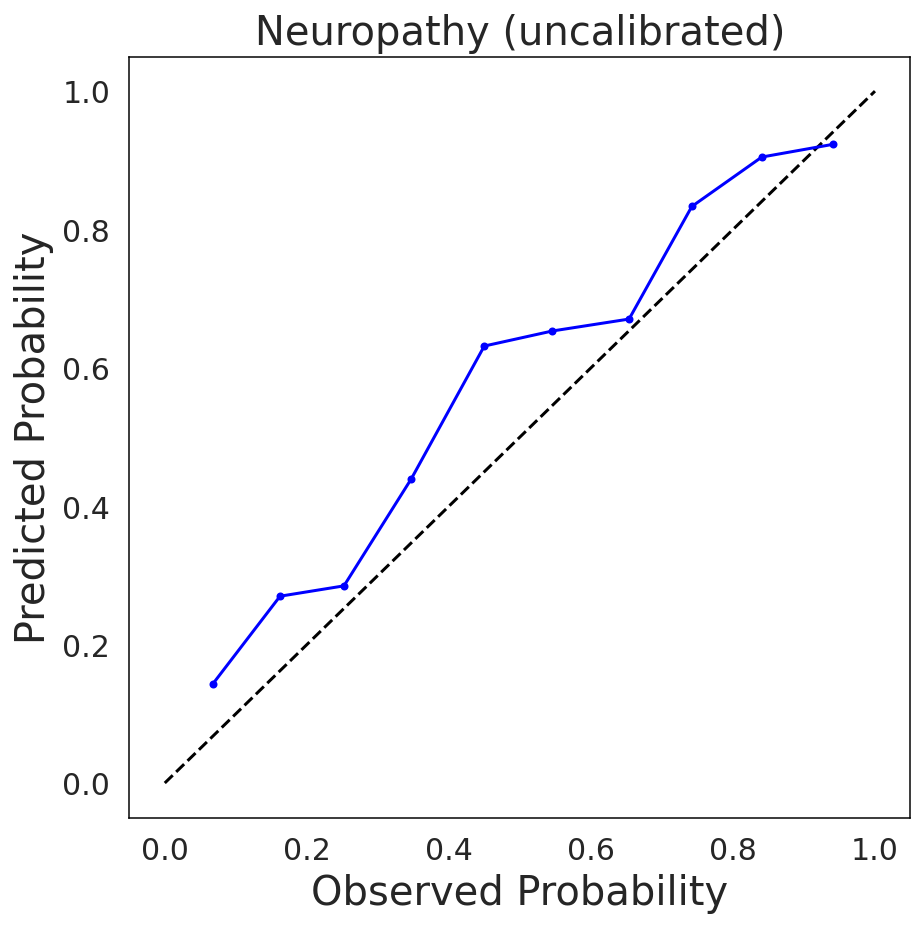

<Figure size 504x504 with 0 Axes>

In [66]:
plt.rcParams['figure.figsize']=7,7
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.75

probs = model.predict_proba(Xtest)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(ytest, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color="black")
# plot model reliability
plt.plot(mpv, fop, marker='.', color="blue")

ypred = model.predict(Xtest)
probs = model.predict_proba(Xtest)
pos_probs = probs[:, 1]
rocauc = roc_auc_score(ytest, pos_probs)
print('AUROC:', rocauc)
bs=brier_score_loss(ytest, pos_probs)
print('Brier Score:', bs)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Observed Probability', fontsize=20, fontweight=100)
plt.ylabel('Predicted Probability', fontsize=20, fontweight=100)
plt.title('Neuropathy (uncalibrated)', fontsize=20, fontweight=100)
plt.grid(False)
plt.figure()

AUCROC: 0.7395504416781012
Brier Score: 0.20732973487532788


<Figure size 504x504 with 0 Axes>

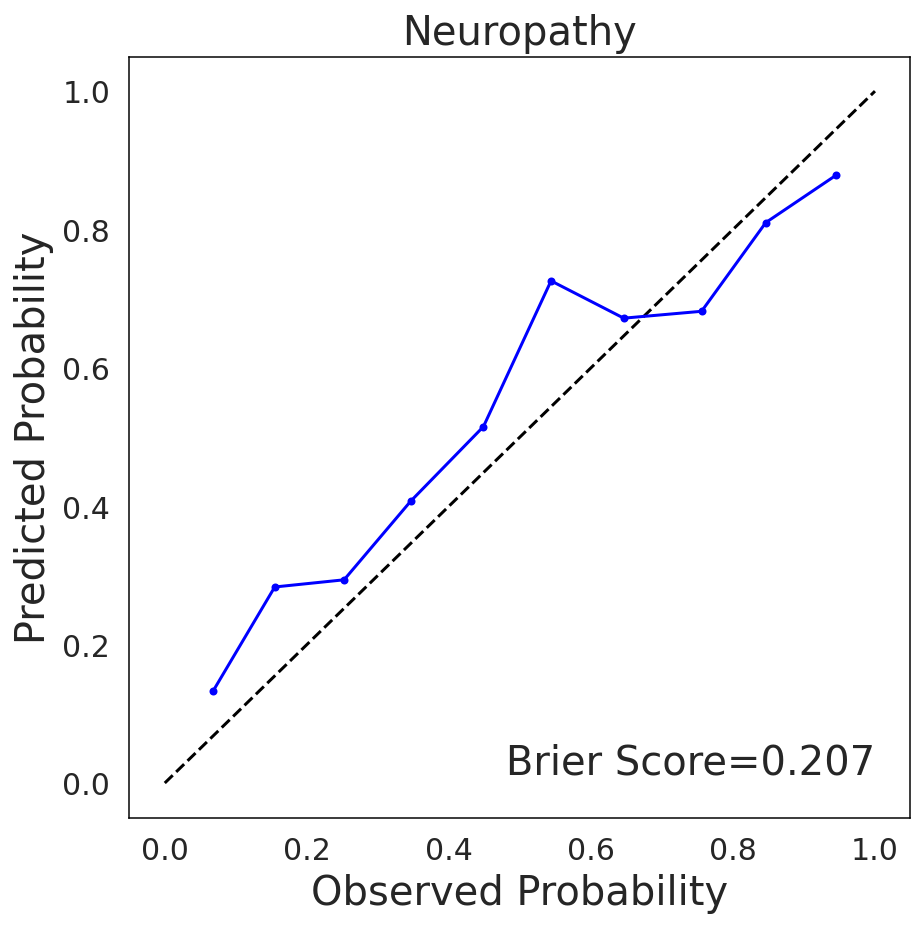

<Figure size 504x504 with 0 Axes>

In [80]:
plt.rcParams['figure.figsize']=7,7
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.75

from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated.fit(Xtrain, ytrain)
# predict probabilities
probs = calibrated.predict_proba(Xtest)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(ytest, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--',color="black")
# plot calibrated reliability
plt.plot(mpv, fop, marker='.',color="blue")

ypred = calibrated.predict(Xtest)
probs = calibrated.predict_proba(Xtest)
pos_probs = probs[:, 1]
rocauc = roc_auc_score(ytest, pos_probs)
print('AUCROC:', rocauc)
bs=brier_score_loss(ytest, pos_probs)
print('Brier Score:', bs)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Observed Probability', fontsize=20, fontweight=100)
plt.ylabel('Predicted Probability', fontsize=20, fontweight=100)
plt.title('Neuropathy', fontsize=20, fontweight=100)
plt.grid(False)
matplotlib.pyplot.text(1,0,'Brier Score=0.207', horizontalalignment='right',
     verticalalignment='bottom',fontsize=20)
plt.savefig(r'./figures/neuro_calib_plot.svg', format='svg')
plt.figure()

### 11. encounters between T2DM dx and comp

In [61]:
neuro_final_clf.to_excel('neuro_out.xlsx')

In [17]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/init_comps_dict.pkl', 'rb') as handle:
    init_comps_dict = pickle.load(handle) 

In [18]:
# creating new dataframe from the above dictionary for time of first complication with the patient number as the index
comps_time_df = pd.DataFrame.from_dict(init_comps_dict, orient='index')
comps_time_df = comps_time_df.apply(pd.to_datetime, errors='coerce')

# sort table by patient number (index)
comps_time_df.sort_index(inplace=True)

In [19]:
comps_time_df.drop(['initial_OPTH','initial_CVD','initial_KIDNEY'],axis=1,inplace=True)

In [20]:
time_to_neuro=neuro_final.to_frame('time_to_neuro(yr)')

In [21]:
merge = comps_time_df.merge(time_to_neuro, left_index=True, right_index=True)

In [22]:
encounters = pd.read_csv(r'/Users/amomenzadeh/Desktop/DM_csv/neuro_encounters.csv',low_memory=False)

In [23]:
encounters.drop(['department_name', 'department_id', 'department_external_name',
       'department_specialty', 'payor_type_primary_c','age_at_visit_years',
       'payor_type_primary_name', 'payer_type_secondary_c','visit_type_id',
       'payer_type_secondary_name', 'appt_status_c', 'appt_status_name','discharge_status_c', 'discharge_status_name',
       'length_of_stay_days', 'hosp_serv_c', 'hosp_serv_name','visit_type_name',
       'adm_for_surg_yn', 'surgical_svc_c', 'surgical_svc_name', 'drg','visit_date_shifted',
       'drg_type', 'drg_name', 'visit_provider_id', 'visit_provider_name','admit_date_shifted',
       'visit_provider_title', 'visit_provider_npi', 'admission_provider_id',
       'admission_provider_name', 'admission_provider_title','admit_source_c','admit_source_name','discharge_date_shifted',
       'admission_provider_npi', 'sourcesystem_cd','encounter_num','enc_type','src_enc_type_c'],inplace=True, axis=1)

In [24]:
encounters.i2b2_date_shifted = pd.to_datetime(encounters.i2b2_date_shifted, format = '%Y-%m-%d') # converted dx date column to datetime

In [25]:
encounters=encounters.sort_values(by='i2b2_date_shifted')

In [26]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/neuro_enc.pkl', 'wb') as handle:
    pickle.dump(encounters, handle)

In [27]:
visits=[]
for x in merge.index:
    enc=encounters[(encounters.patient_num==x)]
    after_DM=enc[(enc.i2b2_date_shifted.values >= merge.loc[[x]].initial_DIAB.values)]
    before_comp=after_DM[(after_DM.i2b2_date_shifted.values <= merge.loc[[x]].initial_NEUROPATH.values)]
    visits.append(len(before_comp.i2b2_date_shifted.unique()))

In [28]:
merge['visits_bw']=visits

In [29]:
merge['visits_bw/yr']=merge['visits_bw']/merge['time_to_neuro(yr)']

In [30]:
merge['output_class']=neuro_final_clf

In [32]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/neur_merge.pkl', 'wb') as handle:
    pickle.dump(merge, handle)

In [33]:
fast=merge[merge['output_class']==1]

In [34]:
slow=merge[merge['output_class']==0]

In [35]:
fast.describe()

,time_to_neuro(yr),visits_bw,visits_bw/yr,output_class
count,2129.000000,2129.000000,2129.000000,2129.0
mean,1.360115,43.085956,43.250647,1.0
std,0.957790,46.966420,43.819734,0.0
min,0.084875,0.000000,0.000000,1.0
25%,0.484610,11.000000,13.974496,1.0
50%,1.196465,27.000000,29.288314,1.0
75%,2.162947,58.000000,57.594557,1.0
max,3.260847,541.000000,373.543466,1.0


In [36]:
slow.describe()

,time_to_neuro(yr),visits_bw,visits_bw/yr,output_class
count,2128.000000,2128.000000,2128.000000,2128.0
mean,6.667824,129.536654,20.551347,0.0
std,2.539361,136.188828,20.804483,0.0
min,3.263585,2.000000,0.154961,0.0
25%,4.579834,31.750000,4.853678,0.0
50%,6.190408,88.000000,14.691020,0.0
75%,8.244522,182.250000,29.019372,0.0
max,15.644401,1936.000000,215.911292,0.0


In [37]:
fast = [25.34, 28.36, 26.39, 29.29]

average = sum(fast) / len(fast)
average

27.345

In [38]:
slow = [15.08, 12.73, 13.53, 14.69]

average = sum(slow) / len(slow)
average

14.0075

In [39]:
merge.loc[merge['output_class']==1 ,'output_class']='Fast'
merge.loc[merge['output_class']==0 ,'output_class']='Slow'

Slow v.s. Fast: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.559e-101 U_stat=1.408e+06


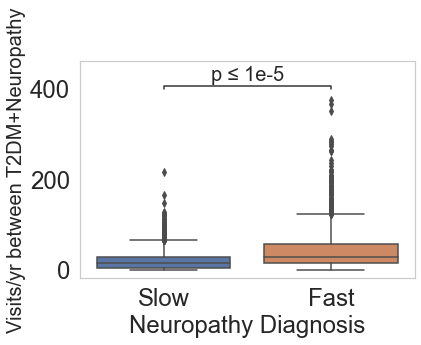

In [40]:
sns.set(style="whitegrid")

x = "output_class"
y = "visits_bw/yr"
order = ['Slow', 'Fast']
ax = sns.boxplot(data=merge, x=x, y=y, order=order)
add_stat_annotation(ax, data=merge, x=x, y=y, order=order,
                    box_pairs=[('Slow','Fast')], 
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2,fontsize=20)
_ = ax.set(xlabel="Diagnosis of Diabetic Complication", ylabel="Visits between T2DM and Neuropathy Diagnoses")

ax.tick_params(labelsize=24)
ax.set_xlabel("Neuropathy Diagnosis",fontsize=24)
ax.set_ylabel("Visits/yr between T2DM+Neuropathy",fontsize=20)
ax.grid(False)
sns.set(rc={'figure.figsize':(6.5,6)})
plt.savefig(r'/Users/amomenzadeh/Desktop/DM_figures/neuro_visits.svg', format='svg',bbox_inches='tight')
plt.show()